In [1]:
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# print(datetime.fromtimestamp(1347517370).strftime('%Y-%m-%d %H:%M:%S'))

In [3]:
import os
print(os.getcwd())

/Users/aneeshussain/Code/diss/analysis


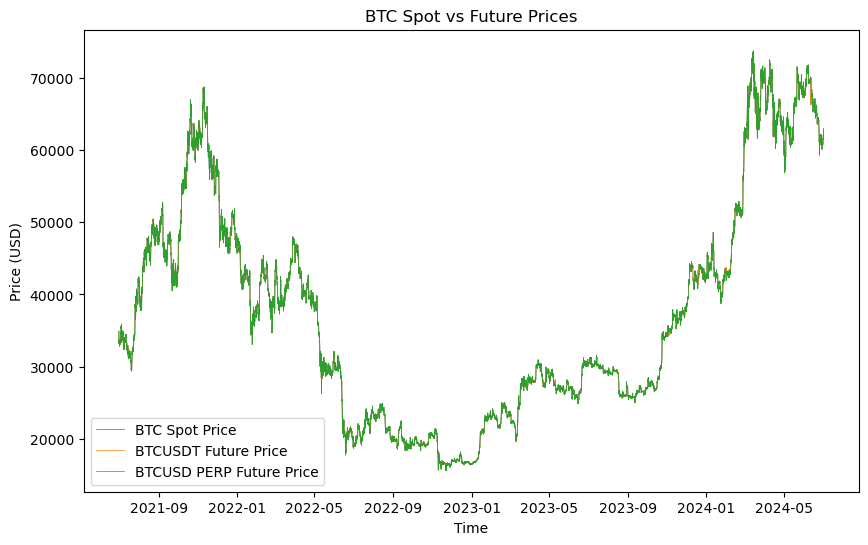

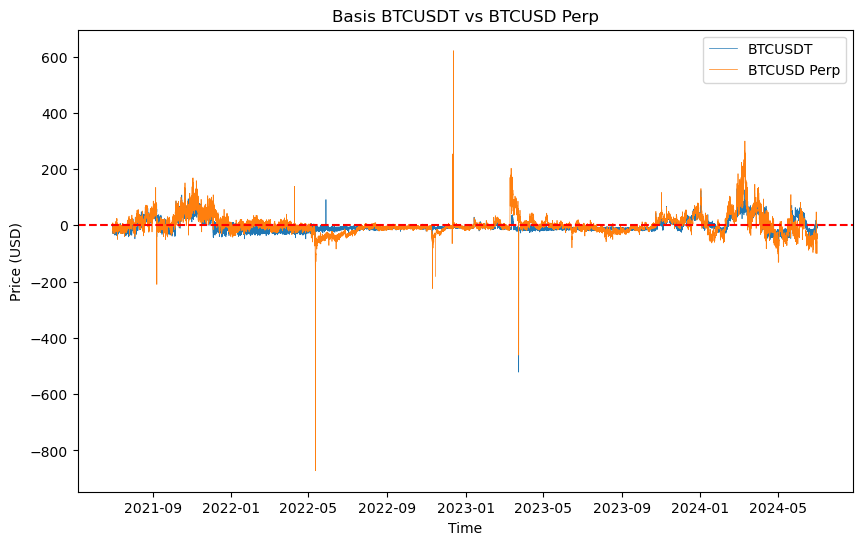

In [14]:
df = pd.read_csv('/Users/aneeshussain/Code/diss/data/processed/Binance_BTC_Basis.csv')

# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['BTCUSDT Spot'], label='BTC Spot Price', linewidth=0.5)
plt.plot(df['Time'], df['BTCUSDT Future'], label='BTCUSDT Future Price', linewidth=0.5)
plt.plot(df['Time'], df['BTCUSD PERP Future'], label='BTCUSD PERP Future Price', linewidth=0.5)
# Adding titles and labels
plt.title('BTC Spot vs Future Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')

# Adding a legend
plt.legend()

# Displaying the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Basis BTCUSDT Future'], label='BTCUSDT', linewidth=0.5)
plt.plot(df['Time'], df['Basis BTCUSD PERP Future'], label='BTCUSD Perp', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.plot
# Adding titles and labels
plt.title('Basis BTCUSDT vs BTCUSD Perp')
plt.xlabel('Time')
plt.ylabel('Price (USD)')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


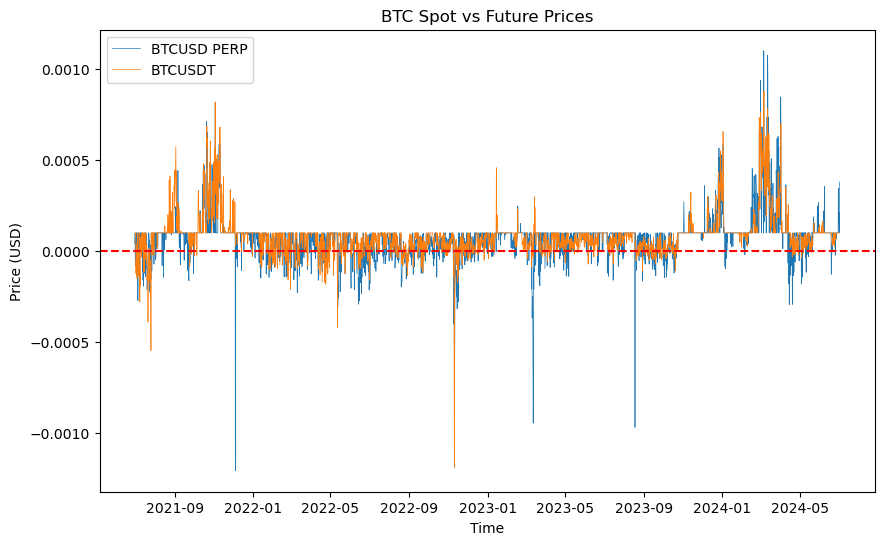

In [13]:
df = pd.read_csv('/Users/aneeshussain/Code/diss/data/processed/Binance_BTCUSD_PERP_Funding_Rate.csv')
df1 = pd.read_csv('/Users/aneeshussain/Code/diss/data/processed/Binance_BTCUSDT_Funding_Rate.csv')

# Convert the 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])
df1['Time'] = pd.to_datetime(df1['Time'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Funding Rate'], label='BTCUSD PERP', linewidth=0.5)
plt.plot(df['Time'], df1['Funding Rate'], label='BTCUSDT', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--')
# Adding titles and labels
plt.title('BTC Spot vs Future Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()